# CS412 - Machine Learning - 2024-2025
## Homework 4


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

Build a gender classifier using the PyTorch library and a pretrained VGG-16 model on the CelebA dataset. Your goal is to complete the given code without changing the base architecture of VGG-16 (other than replacing the classification head suitable for binary classification).

You will:
- Freeze the convolutional layers of the pretrained model  
- Replace the classifier head with your own binary classification layer  
- Fine-tune the model on the given subset of CelebA  
- Experiment with different values of learning rate, batch size, and number of epochs  

**Dataset:** CelebA  
**Model:** VGG-16
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.

##1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [141]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [142]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [143]:
data = pd.read_csv('/content/drive/My Drive/CelebA30k.csv') # enter the file path on your drive for the csv file
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [144]:
gender_data = data[['filename', 'Male']].copy()
gender_data.head()

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [145]:
# This will extract the contents of the zip file into a folder named data
# Do not extract the zip into your google drive

!unzip "/content/drive/My Drive/CelebA30k.zip" -d "/content/data"

Archive:  /content/drive/My Drive/CelebA30k.zip
replace /content/data/CelebA30k/003301.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [146]:
first_image_path = os.path.join("/content/data/CelebA30k/", gender_data.loc[0,"filename"])
img = Image.open(first_image_path)

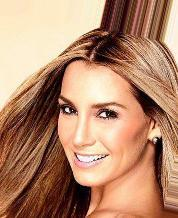

In [147]:
img

# Starting here, you’ll need to fill in the code cells on your own.

##3) Visualizing/Understanding the dataset

- Display five random images together with their labels

- Display statistics about the dataset, such as distribution of labels, etc.


In [148]:
# ===============================
# STEP 1: Import Required Libraries
# ===============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random


In [149]:
# ===============================
# STEP 2: Load CSV with Original Labels
# ===============================
# Read the CelebA30k.csv file that contains image names and attribute labels
data = pd.read_csv('/content/drive/My Drive/CelebA30k.csv')

# Extract only the filename and Male columns (keep original labels: -1 for female, 1 for male)
gender_data = data[['filename', 'Male']].copy()


In [150]:
gender_data

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
29995,029996.jpg,1
29996,029997.jpg,1
29997,029998.jpg,-1
29998,029999.jpg,-1


In [151]:
# ===============================
# STEP 3: Display 5 Random Images with Labels (-1 or 1)
# ===============================
# Randomly sample 5 rows from the dataset
sampled_data = gender_data.sample(5, random_state=42).reset_index(drop=True)


In [152]:
sampled_data

,filename,Male
0,002309.jpg,1
1,022405.jpg,-1
2,023398.jpg,1
3,025059.jpg,-1
4,002665.jpg,1


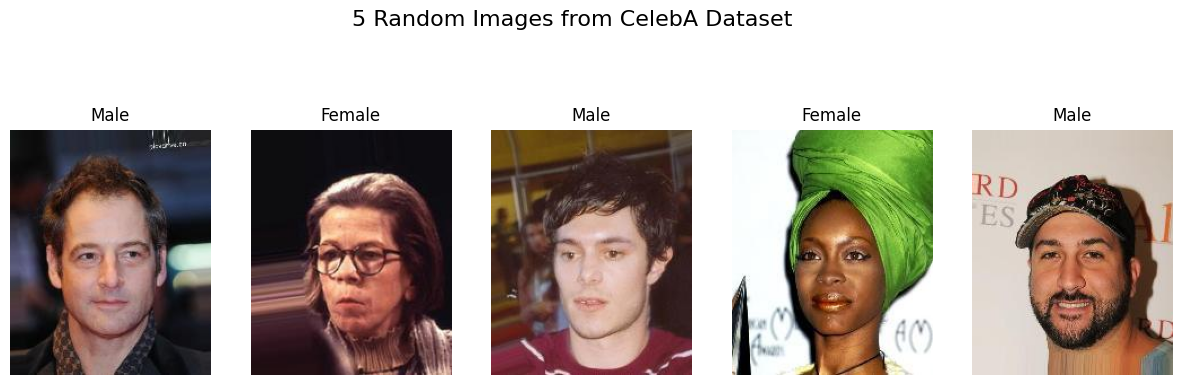

In [153]:
# Set up the figure for plotting 5 subplots side by side
plt.figure(figsize=(15, 5))

for i in range(5):
    # Build full path to the image file
    img_path = os.path.join("/content/data/CelebA30k/", sampled_data.loc[i, "filename"])

    # Get the label: -1 = Female, 1 = Male
    label = sampled_data.loc[i, "Male"]

    # Open the image
    img = Image.open(img_path)

    # Plot the image in the subplot
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.title("Male" if label == 1 else "Female")
    plt.axis("off")  # Hide axis lines

# Add an overall title
plt.suptitle("5 Random Images from CelebA Dataset", fontsize=16)
plt.show()


In [154]:
# STEP 4: General Statistics Summary
print("📊 Dataset Overview\n" + "-"*25)

# Total samples
total = len(gender_data)
print(f"Total number of images: {total}")

# Unique filenames
unique_files = gender_data['filename'].nunique()
print(f"Number of unique filenames: {unique_files}")

# Gender label distribution
label_counts = gender_data["Male"].value_counts().sort_index()
label_names = ["Female (-1)", "Male (1)"]

for val, count in zip(label_counts.index, label_counts.values):
    percent = (count / total) * 100
    label_name = "Female" if val == -1 else "Male"
    print(f"{label_name} ({val}): {count} samples ({percent:.2f}%)")

# Most common label
most_common_label = "Male" if label_counts.idxmax() == 1 else "Female"
print(f"Most frequent label: {most_common_label}")

# Least common label
least_common_label = "Male" if label_counts.idxmin() == 1 else "Female"
print(f"Least frequent label: {least_common_label}")


📊 Dataset Overview
-------------------------
Total number of images: 30000
Number of unique filenames: 30000
Female (-1): 17320 samples (57.73%)
Male (1): 12680 samples (42.27%)
Most frequent label: Female
Least frequent label: Male


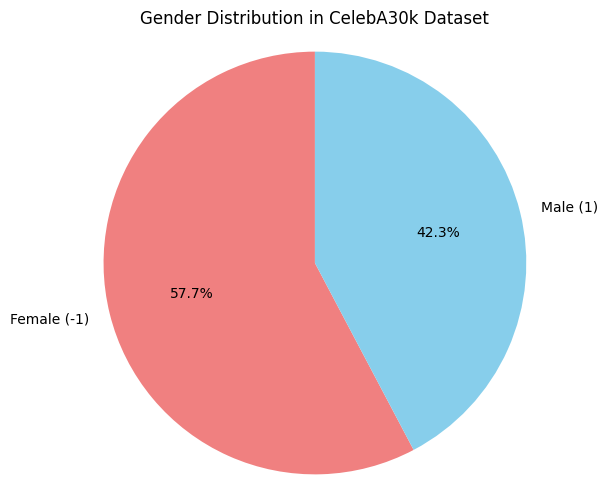

In [155]:
# STEP 5: Pie Chart for Gender Distribution
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_names,
    autopct='%1.1f%%',
    startangle=90,
    colors=["lightcoral", "skyblue"]
)
plt.title("Gender Distribution in CelebA30k Dataset")
plt.axis("equal")
plt.show()


In [156]:
gender_data

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
29995,029996.jpg,1
29996,029997.jpg,1
29997,029998.jpg,-1
29998,029999.jpg,-1


In [157]:
# STEP 6: Image Dimension Statistics on a Sample (e.g., 200 images)
sample_paths = gender_data.sample(200, random_state=42)["filename"]

widths, heights = [], []

for fname in sample_paths:
    img_path = os.path.join("/content/data/CelebA30k/", fname)
    with Image.open(img_path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

print("\n🖼️ Sample Image Dimension Stats (200 samples):")
print(f"Average width:  {np.mean(widths):.2f}")
print(f"Average height: {np.mean(heights):.2f}")
print(f"Min resolution: {min(widths)}x{min(heights)}")
print(f"Max resolution: {max(widths)}x{max(heights)}")



🖼️ Sample Image Dimension Stats (200 samples):
Average width:  178.00
Average height: 218.00
Min resolution: 178x218
Max resolution: 178x218


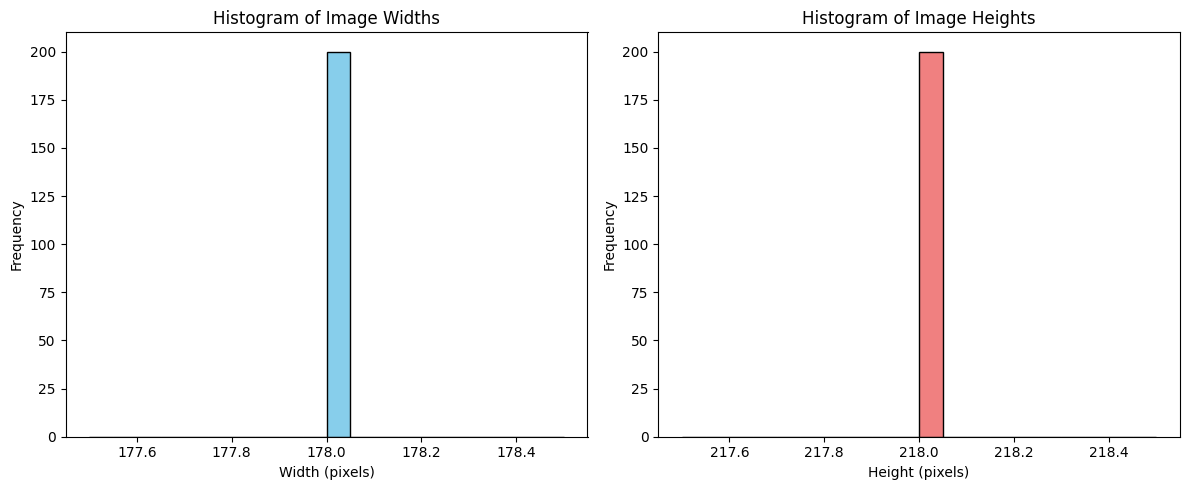

In [158]:
# STEP 7: Histogram of Image Widths and Heights
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, color="skyblue", edgecolor="black")
plt.title("Histogram of Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, color="lightcoral", edgecolor="black")
plt.title("Histogram of Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


##4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [159]:
gender_data

,filename,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
29995,029996.jpg,1
29996,029997.jpg,1
29997,029998.jpg,-1
29998,029999.jpg,-1


In [160]:
from sklearn.model_selection import train_test_split

# First, split off the 10% test set
train_val_data, test_data = train_test_split(
    gender_data,
    test_size=0.1,                 # 10% test
    random_state=42,
    stratify=gender_data['Male']  # Preserve gender distribution
)

# Now split the remaining 90% into 80% train and 10% validation
# Since we're splitting from the 90%, validation becomes 1/9 ≈ 11.11%
train_data, val_data = train_test_split(
    train_val_data,
    test_size=0.1111,                  # 10% of total = 11.11% of remaining 90%
    random_state=42,
    stratify=train_val_data['Male']   # Again stratify
)


In [161]:
# Function to print label breakdown in each split
def print_split_info(name, df):
    total = len(df)
    label_counts = df['Male'].value_counts().sort_index()
    print(f"\n{name} Set: {total} samples")
    for val, count in label_counts.items():
        percent = (count / total) * 100
        label_name = "Female" if val == -1 else "Male"
        print(f"{label_name} ({val}): {count} samples ({percent:.2f}%)")

# Display split info
print_split_info("Training", train_data)
print_split_info("Validation", val_data)
print_split_info("Test", test_data)



Training Set: 24000 samples
Female (-1): 13856 samples (57.73%)
Male (1): 10144 samples (42.27%)

Validation Set: 3000 samples
Female (-1): 1732 samples (57.73%)
Male (1): 1268 samples (42.27%)

Test Set: 3000 samples
Female (-1): 1732 samples (57.73%)
Male (1): 1268 samples (42.27%)


## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Male`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5], [0.5]` for simplicity)
   - Add data augmentation (e.g., horizontal flip) for training
2. Write a custom `Dataset` class that reads images and labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size

In [162]:
# Define Transformations (with Augmentation for Training)

from torchvision import transforms

# Transformation for training data (with horizontal flip for augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize image to 224x224
    transforms.RandomHorizontalFlip(),          # Data augmentation
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize([0.5], [0.5])           # Normalize to [-1, 1] range
])

# Transformation for validation/test data (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [163]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class CelebADataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            dataframe (DataFrame): DataFrame containing 'filename' and 'Male' columns
            root_dir (str): Path to the directory where images are stored
            transform (callable, optional): Optional transform to be applied on a sample
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        # Total number of samples
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Retrieve filename and raw label
        img_name = self.dataframe.loc[idx, 'filename']
        raw_label = self.dataframe.loc[idx, 'Male']  # -1 for female, 1 for male

        # Convert label: -1 → 0 (female), 1 → 1 (male)
        label = 0 if raw_label == -1 else 1
        label = torch.tensor(label, dtype=torch.float32)  # BCEWithLogitsLoss expects float

        # Full path to the image
        img_path = os.path.join(self.root_dir, img_name)

        # Load and convert image to RGB
        image = Image.open(img_path).convert("RGB")

        # Apply image transformations (if provided)
        if self.transform:
            image = self.transform(image)

        return image, label


'''

✅ This class is now fully compatible with:

Pretrained CNNs like VGG or AlexNet

BCEWithLogitsLoss

3-channel RGB inputs

Any transform pipeline using torchvision.transforms


  '''


'\n\n✅ This class is now fully compatible with:\n\nPretrained CNNs like VGG or AlexNet\n\nBCEWithLogitsLoss\n\n3-channel RGB inputs\n\nAny transform pipeline using torchvision.transforms\n\n\n  '

In [164]:
# Create DataLoaders

from torch.utils.data import DataLoader

# Define batch size
batch_size = 64

# Create dataset instances
train_dataset = CelebADataset(train_data, root_dir="/content/data/CelebA30k", transform=train_transform)
val_dataset   = CelebADataset(val_data,   root_dir="/content/data/CelebA30k", transform=val_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)


## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for gender classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with pretrained=True from torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [165]:
import torch.nn as nn
from torchvision import models

def build_vgg16_model():
    # Load pretrained VGG-16 model (trained on ImageNet)
    model = models.vgg16(pretrained=True)

    # Freeze all convolutional layers (optional, we'll control this later during fine-tuning)
    for param in model.features.parameters():
        param.requires_grad = False

    # Get the input features of the last layer in the original classifier
    in_features = model.classifier[-1].in_features  # 4096 for VGG-16

    # Replace the classifier head with a custom binary classifier
    # No sigmoid at the end — we'll use BCEWithLogitsLoss
    model.classifier[-1] = nn.Linear(in_features, 1)

    return model


In [166]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,}")

# Build and inspect model
model = build_vgg16_model()
model.to(device)
count_parameters(model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Total parameters: 134,264,641
Trainable parameters: 119,549,953


In [167]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [168]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.weight False
features.0.bias False
features.2.weight False
features.2.bias False
features.5.weight False
features.5.bias False
features.7.weight False
features.7.bias False
features.10.weight False
features.10.bias False
features.12.weight False
features.12.bias False
features.14.weight False
features.14.bias False
features.17.weight False
features.17.bias False
features.19.weight False
features.19.bias False
features.21.weight False
features.21.bias False
features.24.weight False
features.24.bias False
features.26.weight False
features.26.bias False
features.28.weight False
features.28.bias False
classifier.0.weight True
classifier.0.bias True
classifier.3.weight True
classifier.3.bias True
classifier.6.weight True
classifier.6.bias True


## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:
- Experiment with two different fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block and the classifier head, and train them.
- Choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- Use `nn.BCEWithLogitsLoss()` as the loss function.
  - Note: Since you are using nn.BCEWithLogitsLoss(), your model's output should not have a Sigmoid activation. This loss function applies the Sigmoid operation internally.
- Implement a training loop that includes validation after each epoch.
- Monitor both training and validation performance across epochs.

Hyperparameter Tuning:
- Try two different learning rates: 0.001 and 0.0001.
- The number of training epochs must be fixed to 10.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

Finally, you should report:
- Final training and validation accuracy for each configuration.
- A plot showing training and validation loss across epochs.
- A brief discussion comparing the results for different fine-tuning strategies and learning rates, identifying which combination performed best and why.


In [169]:
# Freeze Strategy Control

def set_parameter_requires_grad(model, strategy="head_only"):
    """
    Freezes/unfreezes layers depending on the fine-tuning strategy.
    strategy = "head_only" → Freeze all conv layers
    strategy = "last_block" → Unfreeze last conv block + classifier
    """
    if strategy == "head_only":
        for param in model.features.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True

    elif strategy == "last_block":
        for param in model.features[:24].parameters():
            param.requires_grad = False  # Freeze first 24 layers
        for param in model.features[24:].parameters():
            param.requires_grad = True   # Unfreeze last conv block
        for param in model.classifier.parameters():
            param.requires_grad = False
        for param in model.classifier[6].parameters():
            param.requires_grad = True


In [170]:
# Training Function (with Validation and Best Model Saving)

def train_model(model, train_loader, val_loader, lr, strategy, num_epochs=10):
    print(f"Training strategy: {strategy}, learning rate: {lr}")

    model = model.to(device)
    set_parameter_requires_grad(model, strategy)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Track the best model
    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct_val, total_val = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss_epoch = val_loss / total_val
        val_acc = correct_val / total_val
        val_losses.append(val_loss_epoch)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss_epoch:.4f}, Acc: {val_acc:.4f}")

        # Save best model if validation accuracy improved
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    # Save the best model weights to a file
    filename = f"best_model_{strategy}_lr{lr}.pth"
    torch.save(best_model_state, filename)
    print(f"✅ Best model saved as: {filename} (Val Acc: {best_val_acc:.4f})")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "best_val_acc": best_val_acc,
        "model_path": filename
    }


In [171]:
# Plotting Function

def plot_loss_and_accuracy(metrics, title="Training Results"):
    epochs = range(1, len(metrics["train_losses"]) + 1)

    plt.figure(figsize=(14,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, metrics["train_losses"], label='Train Loss')
    plt.plot(epochs, metrics["val_losses"], label='Val Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, metrics["train_accuracies"], label='Train Acc')
    plt.plot(epochs, metrics["val_accuracies"], label='Val Acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.suptitle(title)
    plt.show()


Training strategy: head_only, learning rate: 0.001
Epoch 1/10 | Train Loss: 0.2574, Acc: 0.8929 | Val Loss: 0.2345, Acc: 0.9073
Epoch 2/10 | Train Loss: 0.2395, Acc: 0.9024 | Val Loss: 0.2226, Acc: 0.9087
Epoch 3/10 | Train Loss: 0.2331, Acc: 0.9038 | Val Loss: 0.2186, Acc: 0.9130
Epoch 4/10 | Train Loss: 0.2361, Acc: 0.9038 | Val Loss: 0.2179, Acc: 0.9150
Epoch 5/10 | Train Loss: 0.2346, Acc: 0.9032 | Val Loss: 0.2183, Acc: 0.9130
Epoch 6/10 | Train Loss: 0.2337, Acc: 0.9045 | Val Loss: 0.2186, Acc: 0.9137
Epoch 7/10 | Train Loss: 0.2361, Acc: 0.9030 | Val Loss: 0.2185, Acc: 0.9160
Epoch 8/10 | Train Loss: 0.2312, Acc: 0.9064 | Val Loss: 0.2174, Acc: 0.9147
Epoch 9/10 | Train Loss: 0.2318, Acc: 0.9065 | Val Loss: 0.2126, Acc: 0.9157
Epoch 10/10 | Train Loss: 0.2342, Acc: 0.9064 | Val Loss: 0.2140, Acc: 0.9147
✅ Best model saved as: best_model_head_only_lr0.001.pth (Val Acc: 0.9160)


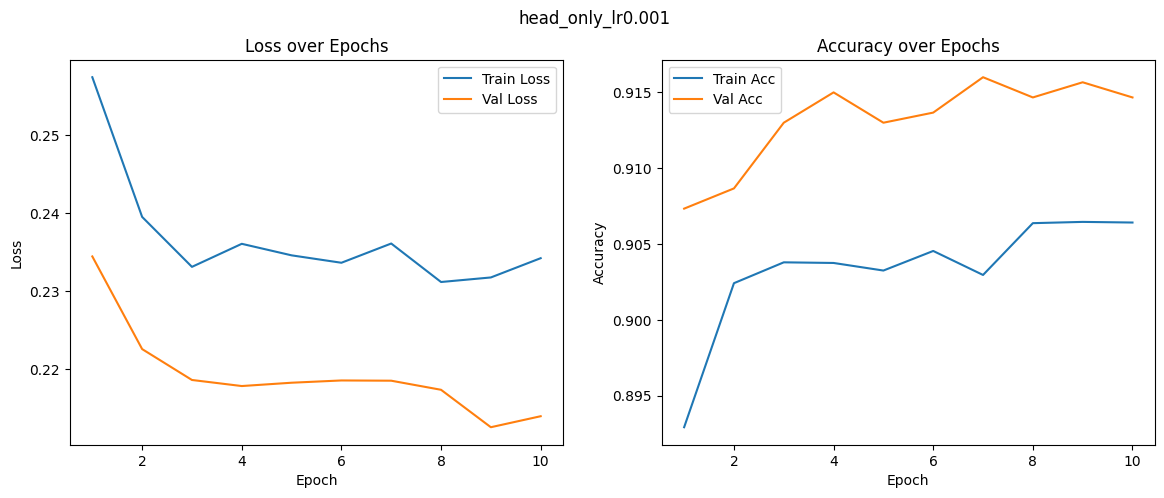

Training strategy: head_only, learning rate: 0.0001
Epoch 1/10 | Train Loss: 0.3705, Acc: 0.8546 | Val Loss: 0.2829, Acc: 0.8920
Epoch 2/10 | Train Loss: 0.2681, Acc: 0.8923 | Val Loss: 0.2572, Acc: 0.9013
Epoch 3/10 | Train Loss: 0.2513, Acc: 0.8993 | Val Loss: 0.2472, Acc: 0.9047
Epoch 4/10 | Train Loss: 0.2428, Acc: 0.9013 | Val Loss: 0.2392, Acc: 0.9100
Epoch 5/10 | Train Loss: 0.2402, Acc: 0.9028 | Val Loss: 0.2364, Acc: 0.9067
Epoch 6/10 | Train Loss: 0.2371, Acc: 0.9033 | Val Loss: 0.2333, Acc: 0.9093
Epoch 7/10 | Train Loss: 0.2335, Acc: 0.9054 | Val Loss: 0.2312, Acc: 0.9100
Epoch 8/10 | Train Loss: 0.2314, Acc: 0.9070 | Val Loss: 0.2285, Acc: 0.9110
Epoch 9/10 | Train Loss: 0.2328, Acc: 0.9050 | Val Loss: 0.2281, Acc: 0.9120
Epoch 10/10 | Train Loss: 0.2309, Acc: 0.9066 | Val Loss: 0.2268, Acc: 0.9123
✅ Best model saved as: best_model_head_only_lr0.0001.pth (Val Acc: 0.9123)


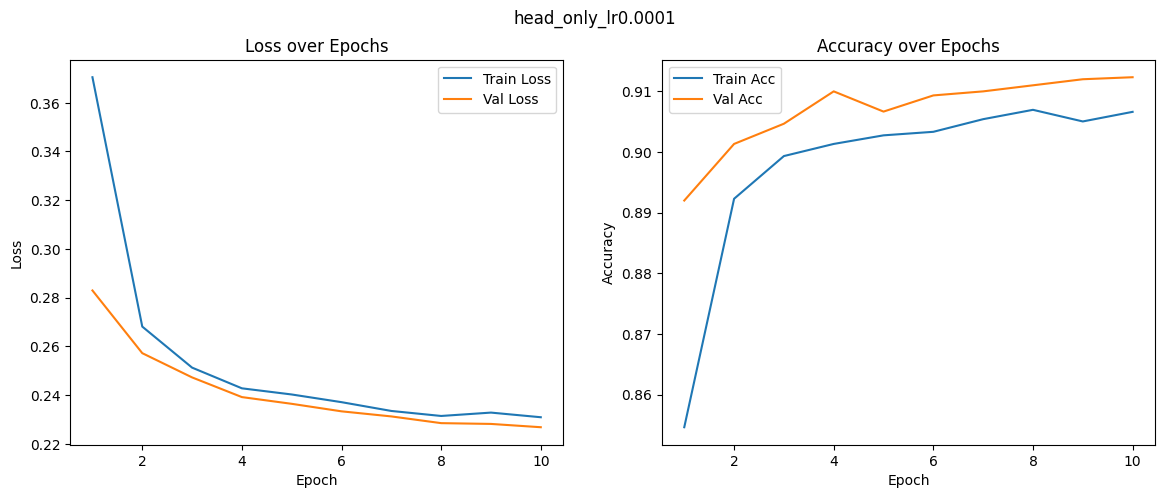

Training strategy: last_block, learning rate: 0.001
Epoch 1/10 | Train Loss: 0.1670, Acc: 0.9326 | Val Loss: 0.1743, Acc: 0.9330
Epoch 2/10 | Train Loss: 0.0891, Acc: 0.9679 | Val Loss: 0.0713, Acc: 0.9750
Epoch 3/10 | Train Loss: 0.0686, Acc: 0.9752 | Val Loss: 0.0810, Acc: 0.9700
Epoch 4/10 | Train Loss: 0.0608, Acc: 0.9789 | Val Loss: 0.0670, Acc: 0.9763
Epoch 5/10 | Train Loss: 0.0493, Acc: 0.9829 | Val Loss: 0.0784, Acc: 0.9717
Epoch 6/10 | Train Loss: 0.0421, Acc: 0.9853 | Val Loss: 0.0768, Acc: 0.9737
Epoch 7/10 | Train Loss: 0.0336, Acc: 0.9887 | Val Loss: 0.0721, Acc: 0.9763
Epoch 8/10 | Train Loss: 0.0259, Acc: 0.9912 | Val Loss: 0.0683, Acc: 0.9807
Epoch 9/10 | Train Loss: 0.0281, Acc: 0.9905 | Val Loss: 0.0950, Acc: 0.9713
Epoch 10/10 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0832, Acc: 0.9767
✅ Best model saved as: best_model_last_block_lr0.001.pth (Val Acc: 0.9807)


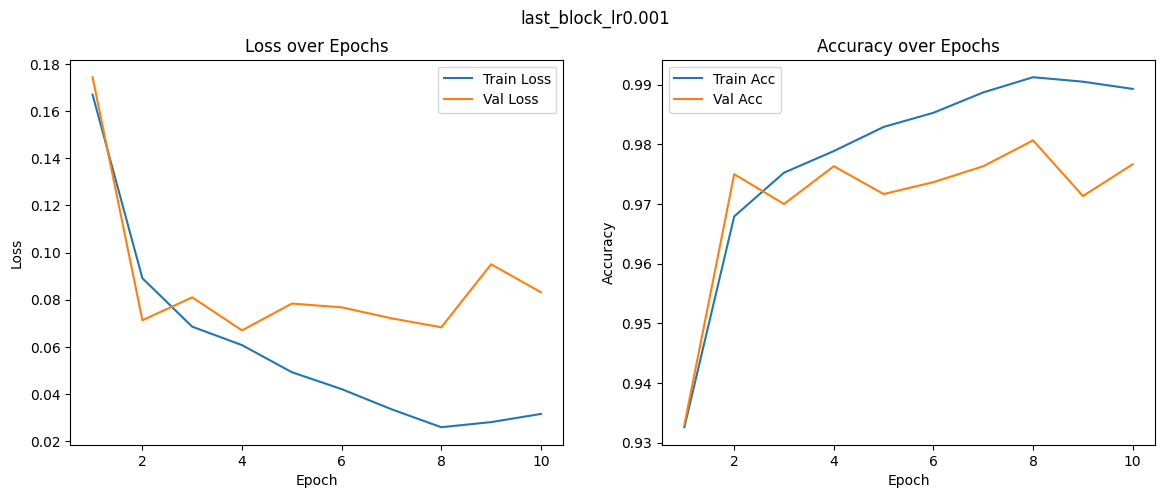

Training strategy: last_block, learning rate: 0.0001
Epoch 1/10 | Train Loss: 0.1404, Acc: 0.9447 | Val Loss: 0.0849, Acc: 0.9683
Epoch 2/10 | Train Loss: 0.0742, Acc: 0.9721 | Val Loss: 0.1335, Acc: 0.9527
Epoch 3/10 | Train Loss: 0.0585, Acc: 0.9790 | Val Loss: 0.0701, Acc: 0.9770
Epoch 4/10 | Train Loss: 0.0443, Acc: 0.9841 | Val Loss: 0.0725, Acc: 0.9753
Epoch 5/10 | Train Loss: 0.0316, Acc: 0.9893 | Val Loss: 0.0865, Acc: 0.9740
Epoch 6/10 | Train Loss: 0.0274, Acc: 0.9899 | Val Loss: 0.0795, Acc: 0.9743
Epoch 7/10 | Train Loss: 0.0193, Acc: 0.9939 | Val Loss: 0.0872, Acc: 0.9740
Epoch 8/10 | Train Loss: 0.0160, Acc: 0.9948 | Val Loss: 0.0930, Acc: 0.9763
Epoch 9/10 | Train Loss: 0.0127, Acc: 0.9963 | Val Loss: 0.0788, Acc: 0.9753
Epoch 10/10 | Train Loss: 0.0087, Acc: 0.9973 | Val Loss: 0.1364, Acc: 0.9623
✅ Best model saved as: best_model_last_block_lr0.0001.pth (Val Acc: 0.9770)


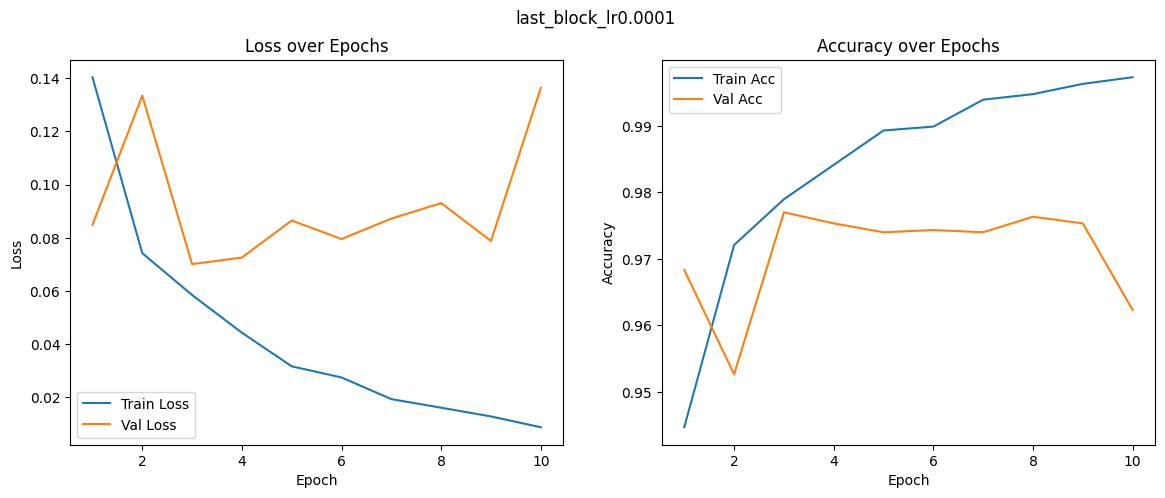

In [172]:
from copy import deepcopy

strategies = ["head_only", "last_block"]
learning_rates = [0.001, 0.0001]

results = {}

for strategy in strategies:
    for lr in learning_rates:
        model = build_vgg16_model()  # fresh model each time
        name = f"{strategy}_lr{lr}"
        metrics = train_model(deepcopy(model), train_loader, val_loader, lr, strategy)
        plot_loss_and_accuracy(metrics, title=name)
        results[name] = metrics


## 8) Test your classifier on Test set

- Use your model to predict the labels of the test set and report the final accuracy.

In [173]:
from sklearn.metrics import accuracy_score

def evaluate_on_test(model, test_loader):
    model.eval()
    model.to(device)
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    print(f"✅ Test Accuracy: {test_acc:.4f}")
    return test_acc, all_preds, all_labels


In [174]:
# Define the path to your image folder
image_dir = "/content/data/CelebA30k"  # Replace if your directory differs

# Create the test dataset and loader
test_dataset = CelebADataset(test_data, root_dir=image_dir, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [175]:
# 1. Build the model again with correct architecture
final_model = build_vgg16_model()

# 2. Set freezing strategy same as training
set_parameter_requires_grad(final_model, strategy="head_only")  # or "last_block"

# 3. Load the best model weights
final_model.load_state_dict(torch.load("best_model_head_only_lr0.0001.pth"))

# 4. Evaluate on test set
#evaluate_on_test(final_model, test_loader)


<All keys matched successfully>

✅ Test Accuracy: 0.9107

📊 Classification Report:
              precision    recall  f1-score   support

      Female       0.91      0.93      0.92      1732
        Male       0.91      0.88      0.89      1268

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



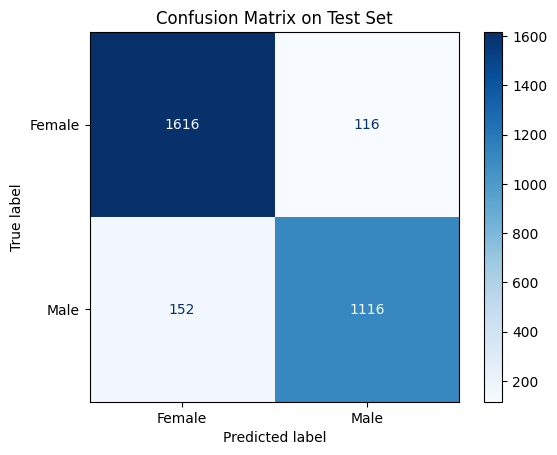

In [176]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Evaluate the model
test_acc, all_preds, all_labels = evaluate_on_test(final_model, test_loader)

# 2. Print classification report (Precision, Recall, F1)
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Female", "Male"]))

# 3. Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 4. Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Female", "Male"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()
